## Getting AI and Human Generated text from our dataset



In [44]:
import pandas as pd
df = pd.read_csv('subset_data.csv')
df = df[df['model'].isin(['llama-3', 'gpt-4o'])]
ai_texts = df['response'].tolist()
hm = pd.read_csv('subset_data.csv')
hm = hm[hm['model']=='human']
hm_texts = hm['response'].tolist()

## Run Dipper Paraphrasing Script to Generate Results

In [ ]:
!python dipper_paraphraser.py

# DETECTION

In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import random
from transformers import (pipeline, AutoTokenizer, AutoModel, T5ForConditionalGeneration, T5Tokenizer, AutoModelForCausalLM)

In [69]:
qd = pd.read_csv('paraphrased_results.csv')
qd_texts = qd['Paraphrased Text'].tolist()

In [70]:
qd = pd.read_csv('paraphrased_results.csv')
qd_texts = qd['Paraphrased Text'].tolist()

ai_data = {'text': qd_texts, 'label': 1, 'source': 'AI'}
human_data = {'text': hm_texts, 'label': 0, 'source': 'Human'}

ai_df = pd.DataFrame(ai_data)
human_df = pd.DataFrame(human_data)
combined_df = pd.concat([ai_df, human_df], ignore_index=True)
random.seed(42)
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df.to_csv('combined_texts.csv', index=False)

print("Data preparation complete. Saved to 'combined_texts.csv'")

Data preparation complete. Saved to 'combined_texts.csv'


### RADAR - getting scores

In [71]:
class Radar():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="TrustSafeAI/RADAR-Vicuna-7B",
            tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
            max_length=512,
            padding='max_length',
            truncation=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [
            (
                score["score"]
                if score["label"] == "LABEL_0"
                else 1 - score["score"]
            )
            for score in scores
        ]



### WILD - getting scores

In [72]:
class Wild():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="nealcly/detection-longformer",
            tokenizer="nealcly/detection-longformer",
            max_length=512,
            truncation=True,
            padding=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [
            score["score"] if score["label"] == 0 else 1 - score["score"]
            for score in scores
        ]

In [73]:
df = pd.read_csv('combined_texts.csv')
responses = df['text'].tolist()

def get_scores(judge):
    return judge.score(responses)

In [74]:
judge = Radar()
scores_radar = get_scores(judge)
judge = Wild()
scores_wild = get_scores(judge)

combined_df = pd.read_csv('combined_texts.csv')
combined_df['wild_score'] = scores_wild
combined_df['radar_score'] = scores_radar
combined_df.to_csv('dipper_scored.csv', index=False)

Device set to use cuda
Device set to use cuda


### RADAR - getting labels

In [75]:
class Radar():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="TrustSafeAI/RADAR-Vicuna-7B",
            tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
            max_length=512,
            padding='max_length',
            truncation=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [score["label"] for score in scores]

### WILD - getting labels

In [76]:
class Wild():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="nealcly/detection-longformer",
            tokenizer="nealcly/detection-longformer",
            max_length=512,
            truncation=True,
            padding=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [score["label"] for score in scores]

In [78]:
df = pd.read_csv('dipper_scored.csv')
responses = df['text'].tolist()

def get_scores(judge):
    return judge.score(responses)

In [79]:
judge = Radar()
scores_radar = get_scores(judge)
judge = Wild()
scores_wild = get_scores(judge)

combined_df = pd.read_csv('dipper_scored.csv')
combined_df['wild_labels'] = scores_wild
combined_df['radar_labels'] = scores_radar
combined_df.to_csv('dipper_scored.csv', index=False)

Device set to use cuda
Device set to use cuda


In [80]:
combined_df = pd.read_csv('dipper_scored.csv')

## AUROC scores on RADAR and WILD Scores




In [81]:
import numpy as np
from sklearn.metrics import roc_auc_score

auroc_radar = roc_auc_score(combined_df['label'], combined_df['radar_score'])
print(f"RADAR AUROC Score: {auroc_radar:.6f}")
auroc_wild = roc_auc_score(combined_df['label'], combined_df['wild_score'])
print(f"WILD AUROC Score: {auroc_wild:.6f}")

RADAR AUROC Score: 0.960667
WILD AUROC Score: 0.974333


# More RADAR Metrics

In [82]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Assuming "LABEL_1" means positive prediction and "LABEL_0" means negative
binary_predictions = (combined_df['radar_labels'] == "LABEL_1").astype(int)

tn, fp, fn, tp = confusion_matrix(combined_df['label'], binary_predictions^1).ravel()
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
print(f"Precision: {precision:.6f}")

# Recall = TP / (TP + FN)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"Recall: {recall:.6f}")

# F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1 Score: {f1:.6f}")

# Accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy:.6f}")

# Attack Success Rate (ASR)
asr = fn / (tp + fn) if (tp + fn) > 0 else 0
print(f"Attack Success Rate: {asr:.6f}")

True Negatives: 46
False Positives: 4
False Negatives: 16
True Positives: 134
Precision: 0.971014
Recall: 0.893333
F1 Score: 0.930556
Accuracy: 0.900000
Attack Success Rate: 0.106667


# More WILD Metrics

In [83]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Assuming "LABEL_1" means positive prediction and "LABEL_0" means negative
binary_predictions = (combined_df['wild_labels'] == 1).astype(int)

tn, fp, fn, tp = confusion_matrix(combined_df['label'], binary_predictions^1).ravel()
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
print(f"Precision: {precision:.6f}")

# Recall = TP / (TP + FN)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"Recall: {recall:.6f}")

# F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1 Score: {f1:.6f}")

# Accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy:.6f}")

# Attack Success Rate (ASR)
asr = fn / (tp + fn) if (tp + fn) > 0 else 0
print(f"Attack Success Rate: {asr:.6f}")

True Negatives: 31
False Positives: 19
False Negatives: 6
True Positives: 144
Precision: 0.883436
Recall: 0.960000
F1 Score: 0.920128
Accuracy: 0.875000
Attack Success Rate: 0.040000


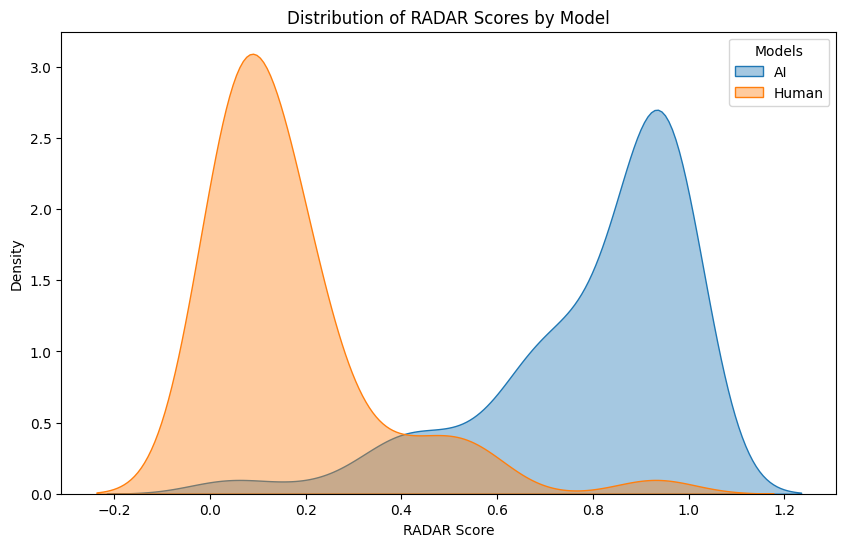

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_col = "source"
score_col = "radar_score"

models = combined_df[model_col].unique()

# Plot KDE for smooth distributions
plt.figure(figsize=(10, 6))
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    sns.kdeplot(subset[score_col].dropna(), label=model, fill=True, alpha=0.4)  # Fill for better visibility

# Add labels and title
plt.xlabel("RADAR Score")
plt.ylabel("Density")
plt.title("Distribution of RADAR Scores by Model")
plt.legend(title="Models")

# Show plot
plt.show()

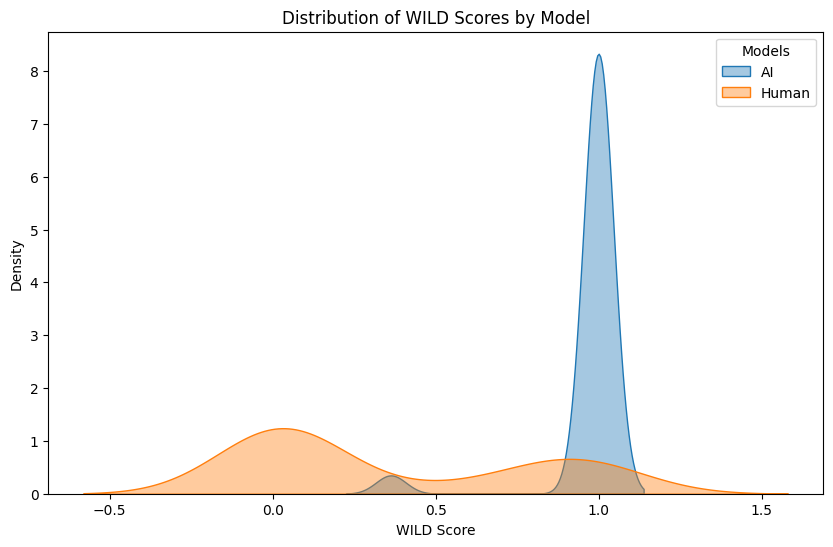

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_col = "source"
score_col = "wild_score"

models = combined_df[model_col].unique()

# Plot KDE for smooth distributions
plt.figure(figsize=(10, 6))
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    sns.kdeplot(subset[score_col].dropna(), label=model, fill=True, alpha=0.4)  # Fill for better visibility

# Add labels and title
plt.xlabel("WILD Score")
plt.ylabel("Density")
plt.title("Distribution of WILD Scores by Model")
plt.legend(title="Models")

# Show plot
plt.show()

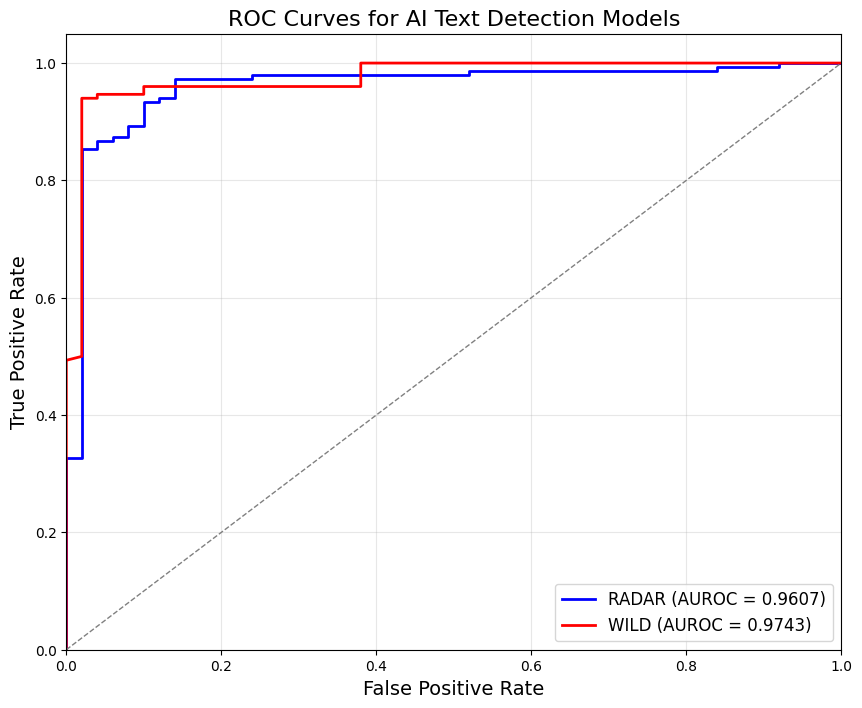

In [86]:
from sklearn.metrics import roc_curve

# Calculate ROC curve points for both detectors
fpr_radar, tpr_radar, _ = roc_curve(combined_df['label'], combined_df['radar_score'])
fpr_wild, tpr_wild, _ = roc_curve(combined_df['label'], combined_df['wild_score'])

# Create a figure with appropriate size
plt.figure(figsize=(10, 8))

# Plot both ROC curves
plt.plot(fpr_radar, tpr_radar, color='blue', lw=2,
         label=f'RADAR (AUROC = {auroc_radar:.4f})')
plt.plot(fpr_wild, tpr_wild, color='red', lw=2,
         label=f'WILD (AUROC = {auroc_wild:.4f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Add labels and formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for AI Text Detection Models', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()